# Data modelling

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import shap

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import lightgbm as lgb

## Load preprocessed dataset as agreed by group

In [2]:
# Load preprocessed data set from /data folder
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
preprocessed_df = pd.read_csv(file_path)

print(preprocessed_df.head())

                  Time Origin Dest                 Carrier  Cancelled  \
0  2021-01-01 09:00:00    LAX  JFK  American Airlines Inc.      False   
1  2021-01-02 09:00:00    LAX  JFK  American Airlines Inc.      False   
2  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
3  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
4  2021-01-04 09:00:00    LAX  JFK  American Airlines Inc.      False   

  CancellationReason  Delayed  DepDelayMinutes  CarrierDelay  \
0      Not Cancelled    False              0.0           0.0   
1      Not Cancelled     True              2.0           0.0   
2      Not Cancelled     True             25.0          28.0   
3      Not Cancelled     True             25.0          28.0   
4      Not Cancelled    False              0.0           0.0   

   Weather_Delay_Length  ...  Temperature  Feels_Like_Temperature  \
0                   0.0  ...         56.0                    55.9   
1                   0.0  ...         5

In [3]:
# Check the datatype of the 'Time' column
print(f"Data type of 'Time': {preprocessed_df['Time'].dtype}")

# If not datetime, convert it to datetime
if not pd.api.types.is_datetime64_any_dtype(preprocessed_df['Time']):
    preprocessed_df['Time'] = pd.to_datetime(preprocessed_df['Time'])
    print(f"After conversion, Data type of 'Time': {preprocessed_df['Time'].dtype}")

Data type of 'Time': object
After conversion, Data type of 'Time': datetime64[ns]


In [4]:
# Extract hour, day of the week, and month from the Time column
preprocessed_df['Hour'] = preprocessed_df['Time'].dt.hour
preprocessed_df['Day_Of_Week'] = preprocessed_df['Time'].dt.dayofweek
preprocessed_df['Month'] = preprocessed_df['Time'].dt.month

## Train and Test split

In [5]:
preprocessed_df.columns

Index(['Time', 'Origin', 'Dest', 'Carrier', 'Cancelled', 'CancellationReason',
       'Delayed', 'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Temperature',
       'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure',
       'Visibility', 'Wind_Speed', 'Wind_Gust', 'Precipitation',
       'Ice_Accretion_3hr', 'Weather_Delayed', 'Hour', 'Day_Of_Week', 'Month'],
      dtype='object')

In [6]:
# Define X and y_pred. Drop all delay columns from X (as per group decision) and 'Delayed' is the new y_pred.
X = preprocessed_df.drop(columns=[
    'Time', 'Cancelled', 'CancellationReason', 'Delayed', 
    'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length', 
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
    'Weather_Delayed'
    ])
y = preprocessed_df['Delayed']

In [7]:
# Checking columns of X
X.columns

Index(['Origin', 'Dest', 'Carrier', 'Temperature', 'Feels_Like_Temperature',
       'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
       'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour',
       'Day_Of_Week', 'Month'],
      dtype='object')

In [8]:
# Train/test split of preprocessed_df while keeping ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 80% train, 20% test
    random_state=42, # Reproducibility
    stratify=y # # Maintain the class distribution
)

In [9]:
# Sample only 10% of the data for quick testing
X_sample, _, y_sample, _ = train_test_split(
    X, y, 
    test_size=0.9,  # Keep only 10% for the sample
    random_state=42, # Reproducibility
    stratify=y  # Maintain the class distribution
)

In [10]:
# Split the sampled data into train and test sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42, # Reproducibility
    stratify=y_sample  # Maintain the class distribution in the split
)

In [13]:
# Define the categorical and numerical features
categorical_features = ['Origin', 'Dest', 'Carrier']
numerical_features = ['Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 
                    'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
                    'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 
                    'Hour', 'Day_Of_Week', 'Month']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Fit the preprocessor on the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train_sample)
X_test_transformed = preprocessor.transform(X_test_sample)

# Get the feature names from the OneHotEncoder and combine with numerical features
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numerical feature names with the one-hot encoded feature names
all_feature_names = numerical_features + list(ohe_feature_names)

# Now, X_train_transformed and X_test_transformed are ready for model training
# all_feature_names contains the correct feature names to be used for plotting or analysis when evaluating the trained model

In [16]:
# # Apply SMOTE to balance the training data
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train_sample)

## FCNN

In [21]:
# Build the FNN model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_transformed.shape[1],), 
                       kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu',
                       kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu',
                       kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Single output for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(X_train_transformed, 
                    y_train_sample, 
                    epochs=30, 
                    batch_size=64, 
                    validation_split=0.1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3), lr_reduction]
                   )

Epoch 1/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 864us/step - accuracy: 0.6093 - loss: 0.7902 - val_accuracy: 0.6096 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 2/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 859us/step - accuracy: 0.6108 - loss: 0.6755 - val_accuracy: 0.6096 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 3/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 855us/step - accuracy: 0.6110 - loss: 0.6753 - val_accuracy: 0.6096 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 4/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 859us/step - accuracy: 0.6099 - loss: 0.6759 - val_accuracy: 0.6096 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 5/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 882us/step - accuracy: 0.6106 - loss: 0.6721 - val_accuracy: 0.6096 - val_loss: 0.6724 - learning_rate: 5.0000e-04
Epoch 6/30
17038/17038 ━━━━━━━━━━━━━━━━━━━━ 15s 881us/step - accuracy: 0.6105 - loss: 0.6722 - val_accuracy: 0.6096 - val_loss: 0.6725 - learning_rate: 5.0000e-04
Epoch 7/30
17038/17038 ━━━━━━━━━━━━━━━

9466/9466 ━━━━━━━━━━━━━━━━━━━━ 3s 309us/step - accuracy: 0.6106 - loss: 0.6686
Test Loss: 0.6684838533401489
Test Accuracy: 0.6107213497161865


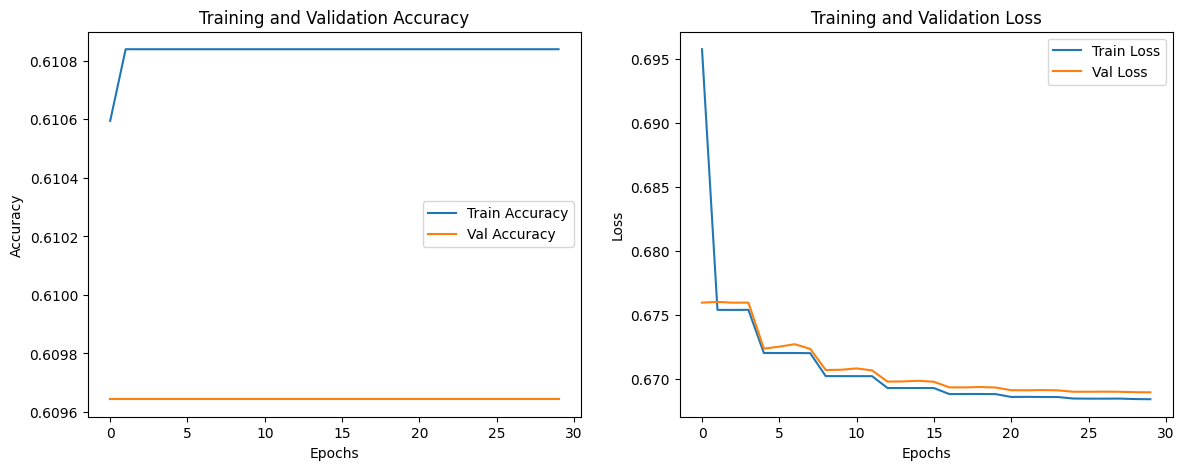

In [22]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test_sample)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot the training and validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [38]:
# Use model.predict to get y_pred values for evaluation
y_pred = model.predict(X_test_transformed)

9466/9466 ━━━━━━━━━━━━━━━━━━━━ 4s 410us/step


In [39]:
y_pred

array([[0.38912103],
       [0.38912103],
       [0.38912103],
       ...,
       [0.38912106],
       [0.38912106],
       [0.38912106]], dtype=float32)

In [40]:
# Calculate F1 score
f1 = f1_score(y_test_sample, y_pred)
print(f"F1 Score on the test set: {f1}")

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [32]:
# Calculate Recall
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

Recall: 0.0


In [33]:
# Calculate ROC AUC
auc_roc = roc_auc_score(y_test_sample, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.5


In [34]:
# Inspect Confusion Matrix
cm = confusion_matrix(y_test_sample, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[184982      0]
 [117909      0]]


In [35]:
# Generate Classification Report
report = classification_report(y_test_sample, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

       False       0.61      1.00      0.76    184982
        True       0.00      0.00      0.00    117909

    accuracy                           0.61    302891
   macro avg       0.31      0.50      0.38    302891
weighted avg       0.37      0.61      0.46    302891



/Users/markmans/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/markmans/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/markmans/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [36]:
# Create a SHAP explainer
# explainer = shap.DeepExplainer(model, X_train_balanced[np.random.choice(X_train_balanced.shape[0], 5000, replace=False)])  # Use DeepExplainer for neural networks
# shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot
# shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar")  # Bar plot for overall feature importance# Detailed summary plot (beeswarm plot)
# shap.summary_plot(shap_values, X_test_preprocessed)  # Beeswarm plot for detailed insights

## LightGBM

In [43]:
# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train_transformed, label=y_train_sample, feature_name=all_feature_names)

test_data = lgb.Dataset(X_test_transformed, label=y_test_sample, reference=train_data)

In [44]:
# Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

In [47]:
# Perform cross-validation with early stopping
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000,
    nfold=5,
    stratified=True,
    shuffle=True,
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)],
    seed=42
)

Training until validation scores don't improve for 10 rounds
[10]	cv_agg's valid binary_logloss: 0.641703 + 0.000172743
[20]	cv_agg's valid binary_logloss: 0.629951 + 0.000343157
[30]	cv_agg's valid binary_logloss: 0.623763 + 0.000431965
[40]	cv_agg's valid binary_logloss: 0.619955 + 0.000482654
[50]	cv_agg's valid binary_logloss: 0.617332 + 0.000451142
[60]	cv_agg's valid binary_logloss: 0.615409 + 0.000483586
[70]	cv_agg's valid binary_logloss: 0.613859 + 0.000515648
[80]	cv_agg's valid binary_logloss: 0.612597 + 0.000497368
[90]	cv_agg's valid binary_logloss: 0.611577 + 0.000534793
[100]	cv_agg's valid binary_logloss: 0.610739 + 0.00052329
[110]	cv_agg's valid binary_logloss: 0.610035 + 0.000508798
[120]	cv_agg's valid binary_logloss: 0.609433 + 0.000538481
[130]	cv_agg's valid binary_logloss: 0.608927 + 0.000528786
[140]	cv_agg's valid binary_logloss: 0.608489 + 0.000539942
[150]	cv_agg's valid binary_logloss: 0.608087 + 0.00055029
[160]	cv_agg's valid binary_logloss: 0.607717 + 0.

In [48]:
# The best number of boosting rounds can be determined from cv_results
best_num_boost_rounds = len(cv_results['binary_logloss-mean'])
print(f"Best number of boosting rounds: {best_num_boost_rounds}")

KeyError: 'binary_logloss-mean'

In [ ]:
# Train the final LightGBM model using the optimal number of rounds
model_lgbm = lgb.train(
    params,
    train_data,
    num_boost_round=best_num_boost_rounds,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

In [ ]:
# Make predictions
y_pred_prob = model_lgbm.predict(X_test_transformed, num_iteration=model_lgbm.best_iteration)
y_pred_lgm = np.round(y_pred_prob)

In [ ]:
# Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_sample, y_pred_lgm)
roc_auc = roc_auc_score(y_test_sample, y_pred_prob)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

In [ ]:
# Calculate F1 score
f1 = f1_score(y_test_sample, y_pred_2)
print(f"F1 Score on the test set: {f1}")

In [ ]:
# Calculate Recall
recall = recall_score(y_test_sample, y_pred_2)
print(f"Recall: {recall}")

In [ ]:
# Generate Classification Report
report = classification_report(y_test_sample, y_pred_2)
print(f"Classification Report:\n{report}")

In [ ]:
# Feature importance
model_lgbm.feature_name = all_feature_names # add back the feature columns names 
lgb.plot_importance(model_lgbm, max_num_features=30)
plt.show()